 # Tienda online Ice

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Etapa 1. Descripción de los datos](#data_review)
* [Etapa 2. Preprocesamiento de datos](#data_preprocessing)
* [Etapa 3. Análisis los datos](#data_analysis)
* [Etapa 4. Perfil por region](#perfil)
* [Etapa 5. Prueba de hipótesis](#hypothesis)
* [Etapa 6. Conclusión general](#conclusion_general)


# Introducción <a id='intro'></a>

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas.

### Objetivo:
Prueba la hipótesis:
1. identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.


### Etapas

Tu proyecto consistirá en siguientes etapas:
 1. Abrir el archivo de datos y estudiar la información general.
 2. Preprocesamiento de datos.
 3. Análisis los datos.
 4. Crea un perfil de usuario para cada región.
 5. Hipótesis.
 6. Conclusión.


# Paso 1. Carga de librerias y de datos a estudiar <a id='data_review'></a>

In [1]:
#->librerias
# Importar librerias
import os
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
#funcionles


def df_to_minusculas(df):
    try:
        tmp_df = df
        columns_new = []
        for columna in tmp_df.columns:
            columns_new.append(columna.lower())
        tmp_df.columns = columns_new
        return tmp_df
    except Exception as err:
        print("------------------")
        print(f"Unexpected {err=}, {type(err)=}")
        print("------------------")
        return NameError


#limpia una columna de tipo string, con valores numericos y valores NAN y una cadena erronea a tipo float
def limpiar_columna(df_tmp, columna,eliminar_caracter):
    try:
        #llenamos los NAN con el valor a eliminar
        df_tmp[columna].fillna(eliminar_caracter, inplace=True)
        #obtenemos solo los valores distintos  a el valor a eliminar
        filtro = df_tmp[df_tmp[columna]  != eliminar_caracter]
        #los valores obtenedios los convertimos a integer y obtenemos sus promedio
        filtro = filtro[columna].astype(str).astype(float)
        #Busca el promedio de la columna 
        mean_value = filtro.mean().round(1)
        df_tmp[columna] = df_tmp[columna].replace(eliminar_caracter,mean_value, regex=True)
        return df_tmp[columna]
    except:
      print('Ocurrio un error on la limpieza de datos')


Declaracion de la función filtrar_dataframe_por_atipicos<a id='funcion_dec'></a>

In [2]:

def filtrar_dataframe_por_atipicos(df, columna, umbral=3):
    """
    Filtra los valores atípicos en una columna de un DataFrame de Pandas y devuelve el DataFrame filtrado.
    
    Args:
        df (DataFrame): El DataFrame de Pandas.
        columna (str): El nombre de la columna a filtrar.
        umbral (int): El umbral para determinar qué valores son atípicos.
    
    Returns:
        DataFrame: El DataFrame filtrado sin los valores atípicos.
    """
    # Calcular la media y la desviación estándar para la columna
    media = df[columna].mean()
    desviacion_estandar = df[columna].std()
    
    # Identificar los valores atípicos
    valores_atipicos = (df[columna] - media).abs() > umbral * desviacion_estandar
    
    # Filtrar el DataFrame
    df_filtrado = df[~valores_atipicos]
    
    return df_filtrado

In [3]:
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga múltiples archivos CSV con separadores específicos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenará los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'games.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
df = df_all.get('games.csv') 


Archivo cargado exitosamente desde 'datasets/games.csv'


In [4]:
print(list(df.columns))
print()
df.info()
display(df.sample(5))

['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
15360,Kill.Switch,GBA,2004.0,Shooter,0.02,0.01,0.00,0.00,NaN,tbd,T
1723,LEGO Indiana Jones: The Original Adventures,PSP,2008.0,Action,0.40,0.48,0.00,0.29,76.0,7.6,E10+
3614,MX 2002 Featuring Ricky Carmichael,PS2,2001.0,Racing,0.27,0.21,0.00,0.07,76.0,8.3,E
15502,Strike Witches: Anata to Dekiru Koto - A Littl...,PS2,2010.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN
14050,Smashing Drive,XB,2002.0,Racing,0.03,0.01,0.00,0.00,42.0,tbd,T


### Conclusiones. <a id='data_review_conclusion'></a>

Se observan los datos de ventas de videojuegos, se cuenta con información relevante como: plataforma donde fue lanzado, año, genero, las ventas en 3 regiones, el puntage del ususario y rating; se cuenta con valores ausentes, por ejemplo: en el año de lanzamiento y en las columnas de puntajes, ademas de algunos datos erroneoa sobre el año de lanzamiento del video juego, ya en la salida del video jego aun no existia la consola.

# Paso 2. Preprocesamiento de datos <a id='data_preprocessing'></a>

In [5]:
# Convertir todos las nombres de columnas a minusculas
df_to_minusculas(df)
print(list(df.columns))

['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


Se detecta que existe valores ausentes en la columa year_of_release.
Se procede a ser reemplazado.

In [6]:
# Convertir a Formato de fecha valido
df['year_of_release'].fillna(0, inplace=True)
df["year_of_release"] = df["year_of_release"].astype(float).astype(int)


Verificar la columna 'user_score'

In [7]:

display(df['user_score'].unique())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Se detecta que existe celdas con valores erroneos, contiene -> 'tbd' en su valor, o valores nulos
Se procede a ser reemplazado.
y convertir la comllumna aun formato correcto

In [8]:
df['user_score'] = limpiar_columna(df, 'user_score', 'tbd')
df['user_score'] = df['user_score'].astype(str).astype(float)
display(df['user_score'].unique())

array([8. , 7.1, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2, 9.2,
       7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8, 6.1,
       6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8, 5.6,
       5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5, 2.5,
       1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. , 1.6,
       9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2, 0.6,
       1.4, 0.9, 1. , 9.7])

Verificar la columna 'critic_score'

In [9]:
display(df['critic_score'].unique())

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Se detecta que existe una celda con valor erroneo, contiene -> NAN en su valor.
Se procede a ser reemplazado.

In [10]:
#mean_value = df['critic_score'].mean().round(1)
#df['critic_score'].fillna(mean_value, inplace=True)
#display(df['critic_score'].unique())

In [11]:
df['critic_score'].fillna('Unknown', inplace=True)
display(df['critic_score'].unique())

C:\Users\Administrador\AppData\Local\Temp\ipykernel_18808\850757518.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['critic_score'].fillna('Unknown', inplace=True)


array([76.0, 'Unknown', 82.0, 80.0, 89.0, 58.0, 87.0, 91.0, 61.0, 97.0,
       95.0, 77.0, 88.0, 83.0, 94.0, 93.0, 85.0, 86.0, 98.0, 96.0, 90.0,
       84.0, 73.0, 74.0, 78.0, 92.0, 71.0, 72.0, 68.0, 62.0, 49.0, 67.0,
       81.0, 66.0, 56.0, 79.0, 70.0, 59.0, 64.0, 75.0, 60.0, 63.0, 69.0,
       50.0, 25.0, 42.0, 44.0, 55.0, 48.0, 57.0, 29.0, 47.0, 65.0, 54.0,
       20.0, 53.0, 37.0, 38.0, 33.0, 52.0, 30.0, 32.0, 43.0, 45.0, 51.0,
       40.0, 46.0, 39.0, 34.0, 35.0, 41.0, 36.0, 28.0, 31.0, 27.0, 26.0,
       19.0, 23.0, 24.0, 21.0, 17.0, 22.0, 13.0], dtype=object)

Verificar la columa 'rating'

In [12]:
display( df['rating'].unique())
ratin_null = df[ df['rating'].isnull()]
porcentaje_valores_nulos = (ratin_null['rating'].size * 100) / df['rating'].size 
size = ratin_null['rating'].size
display(f'Cantidad de valores nulos = {size} ')
display(f'porcentaje_valores_nulos = {porcentaje_valores_nulos} %')


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

'Cantidad de valores nulos = 6766 '

'porcentaje_valores_nulos = 40.478612025127134 %'

Verificamos la tabla de nuevo


In [13]:
# Convertir a Formato tipo float

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  object 
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.3+ MB


In [14]:
# -> convertir a minusculas los valores de la columna platform
df['platform'] =  df['platform'].str.lower()
test = df['platform'].unique() 
print(sorted(test))

['2600', '3do', '3ds', 'dc', 'ds', 'gb', 'gba', 'gc', 'gen', 'gg', 'n64', 'nes', 'ng', 'pc', 'pcfx', 'ps', 'ps2', 'ps3', 'ps4', 'psp', 'psv', 'sat', 'scd', 'snes', 'tg16', 'wii', 'wiiu', 'ws', 'x360', 'xb', 'xone']


In [15]:
# -> convertir a minusculas los valores de la columna genre
df['genre'] =  df['genre'].str.lower()
test = df['genre'].unique() 
display(test)

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy', nan], dtype=object)

Se detecta un valor nullo en la columa genero
se procede a llenar el valor

In [16]:
df['genre'].fillna('sin_genero', inplace=True)
test = df['genre'].unique() 
display(test)

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy', 'sin_genero'], dtype=object)

__Se Realizo un cambio en los siguientes columnas:__

1.- 'year_of_release': se realizo un cambio del tipo string a tipo fecha, para poder trabajar los registros con funciones que nos permiten usar los valores con formao de fecha

2.- 'user_score': se realizo un cambio del tipo string a tipo float, para poder trabajar los valores de la columna con operaaciones matematicas correspondienetes.

3.- 'platform': se realizo un cambio de los valores de la columna, pasando todos sus valores a minusculas.

4.- 'genre': se realizo un llenado de los valores ausentes, con el valor 'sin_genero'.

* se observan algunos datos inconsistentes en la columna 'user_score', se procede aser reemplazados por un valor generado por la mediana de los datos, para no ver comprometidos los resultados de los datos que se desean analizar.

___Se presume que existe una ausencia de datos en la columna 'critic_score' debido a que no se realizó una evaluación de los juegos, ya sea porque no contaban con el rating correspondiente o debido a que en las fechas en las que se obtuvieron los datos, aún no se había realizado dicha evaluación___



#### Ventas Totales por regiones

implementación de la función filtrar_dataframe_por_atipicos<a id='funcion_imp'></a>

In [17]:
df['ventas_totales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']


### Implementacion de la funcion de filtrado de datos atipicos
df = filtrar_dataframe_por_atipicos(df, 'ventas_totales')


display(df.sample(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ventas_totales
15582,Crysis: Warhead,pc,2008,shooter,0.00,0.02,0.0,0.00,84.0,7.9,M,0.02
15301,Iron Phoenix,xb,2005,fighting,0.02,0.00,0.0,0.00,58.0,6.5,T,0.02
1292,Disney Princess,gba,2003,platform,1.04,0.37,0.0,0.06,Unknown,7.1,E,1.47
3558,Arena Football,ps2,2006,sports,0.28,0.22,0.0,0.07,66.0,8.6,E10+,0.57
12094,Strike Point,ps,1996,simulation,0.04,0.03,0.0,0.00,Unknown,7.1,NaN,0.07


# Paso 3. Análisis los datos <a id='data_analysis'></a>

***Inforanción adicional***
fechas de lanzamiento de consolas:

    1.-ps2 - 4/marzo/2000
    2.-Xbox - 22/septiembre/2001
    3.-Ds - 21/noviembre/2004
    4.-Xbox 360 - 22/noviembre/2005
    5.-ps3 - 11/noviembre/2006
    6.-Wii - 19/noviembre/2006
    7.-3ds - 26/febrero/2011
    8.-Sony psp vita - 17/diciembre/2011
    9.-Wii u - 18/noviembre/2012
    10.-ps4 - 15/noviembre/2013
    11.-xbox one - 22/noviembre/2013

    // para finales de año del 2016 ya se sabia la llegada de nitendo switch para el 2017, las consolas que todavia no se sabia su proximo lanzamiento eran las posibles 'ps5' y 'Xbox one series'


Analisis de la cantidad de juegos lanzados por año

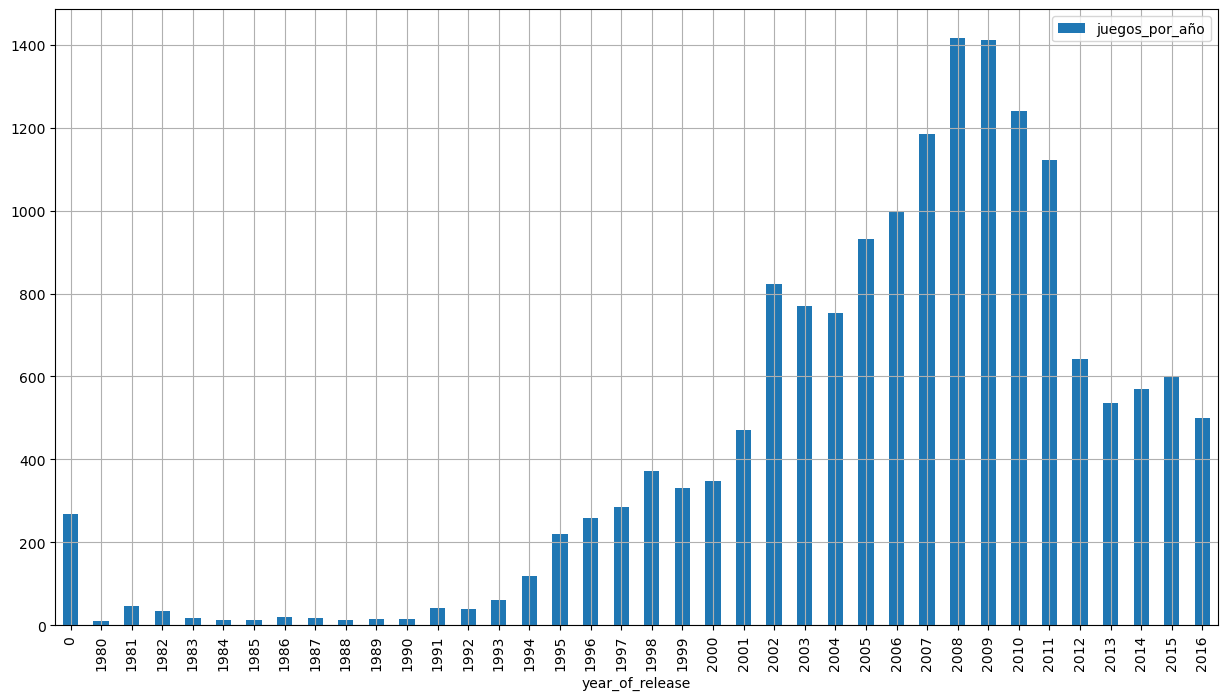

In [18]:

data = df.groupby('year_of_release')['platform'].count().reset_index(name='juegos_por_año')
plt = data.plot(x='year_of_release', y=['juegos_por_año'], kind="bar", figsize=(15, 8), grid=True)

Se aprecia que el mayor numero de lanzamientos de videojuegos a la fecha, fueron del año 2009 al 2010

<Axes: xlabel='year_of_release'>

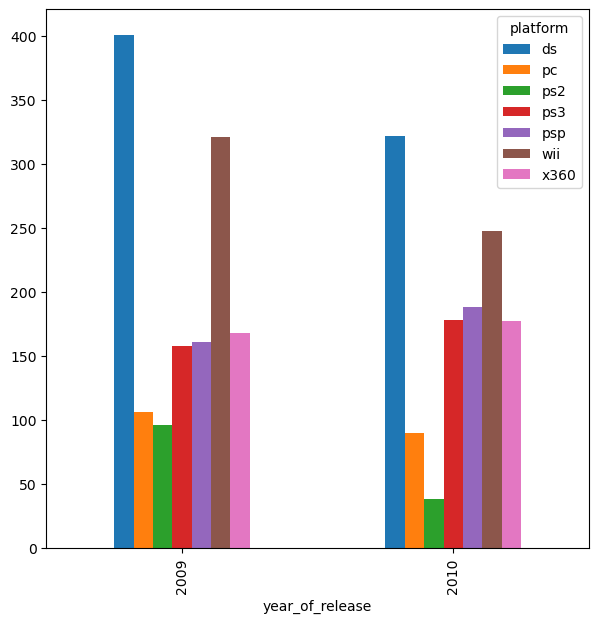

In [19]:
muestra = df[(df['year_of_release'] > 2008) & (df['year_of_release'] < 2011)]
muestra_group = muestra.groupby(['year_of_release','platform'])['platform'].count().reset_index(name='juegos_por_año')
df_pivot = muestra_group.pivot_table(index='year_of_release', columns='platform', values='juegos_por_año')
df_pivot.plot(kind='bar', figsize=(7,7)) 

Al analizar los datos de juegos lanzados de los 2 años con mayores lanzamientos (2008-2009), se puede observar que la compañia nintedo es la que tuvo mayores lanzamientos de video juegos realizo, tanto en su formato de portatil con la nintendo DS y su consola de sobrema Wii

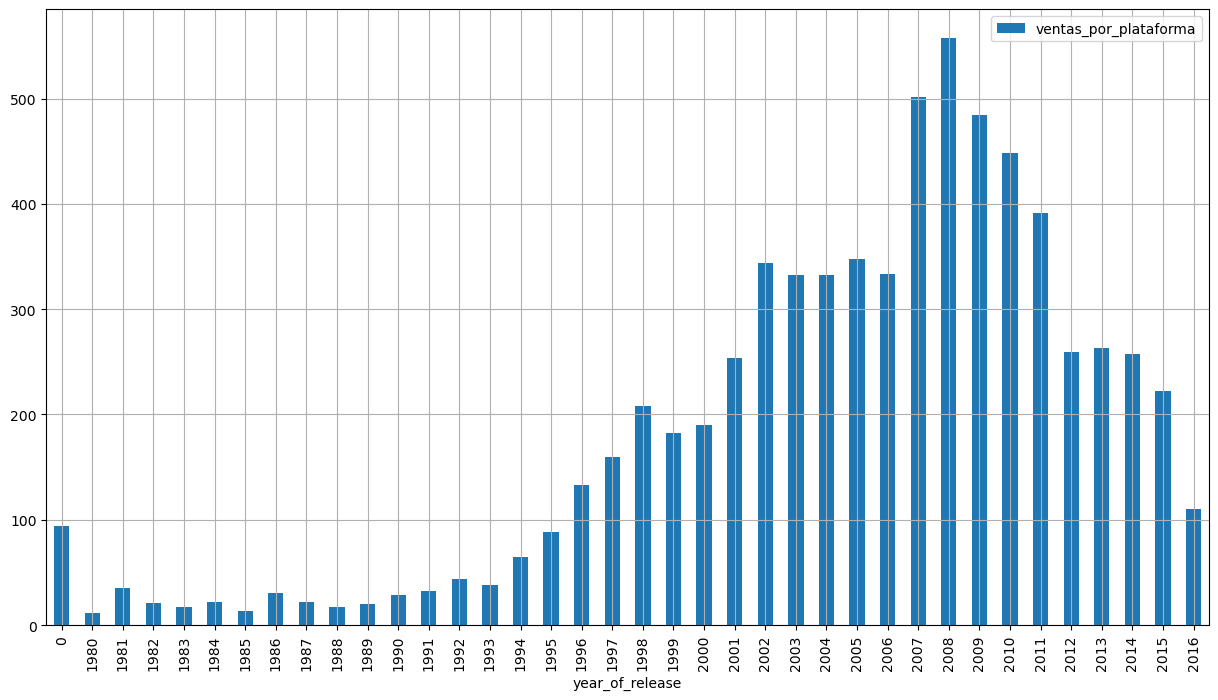

In [20]:
ventas_por_plataforma = df.groupby(['year_of_release'])['ventas_totales'].sum().reset_index(name='ventas_por_plataforma')
#display(ventas_por_plataforma)
plt = ventas_por_plataforma.plot(x='year_of_release', y=['ventas_por_plataforma'], kind="bar", figsize=(15, 8), grid=True)


En el gráfico anterior se aprecia que en los años 2008 y 2009 son los años con mayor venta de videojuegos, siendo que en el año del 2008 tiene un mayor reporte de ventas que el en año del 2009.

<Axes: xlabel='year_of_release'>

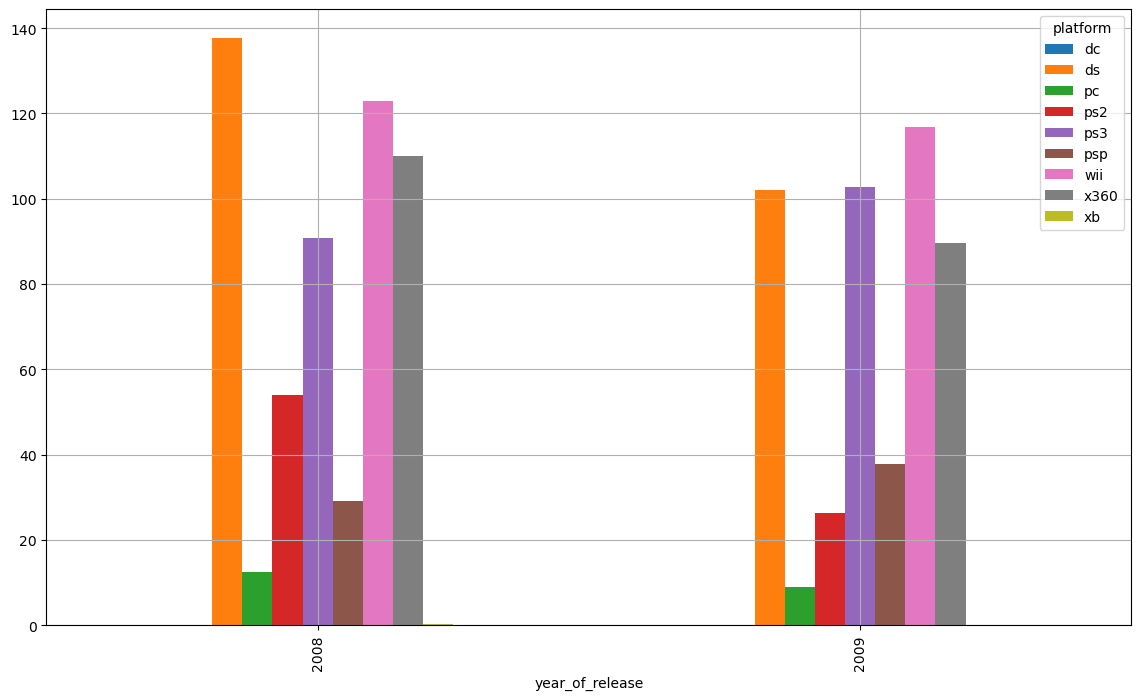

In [21]:
muestra = df[(df['year_of_release'] > 2007) & (df['year_of_release'] < 2010)]
muestra_group = muestra.groupby(['year_of_release','platform'])['ventas_totales'].sum().reset_index(name='ventas_por_plataforma')
df_pivot = muestra_group.pivot_table(index='year_of_release', columns='platform', values='ventas_por_plataforma')
df_pivot.plot(kind='bar', figsize=(14,8), grid=True) 

Se puede apreciar que el mayor número de video juevos vendidos es para la consola wii, en un segundo lugar la consola Ds, ambas de la compañia de nintendo y en un tercer lugar los video juegos de la consola de ps3.

<Axes: xlabel='year_of_release'>

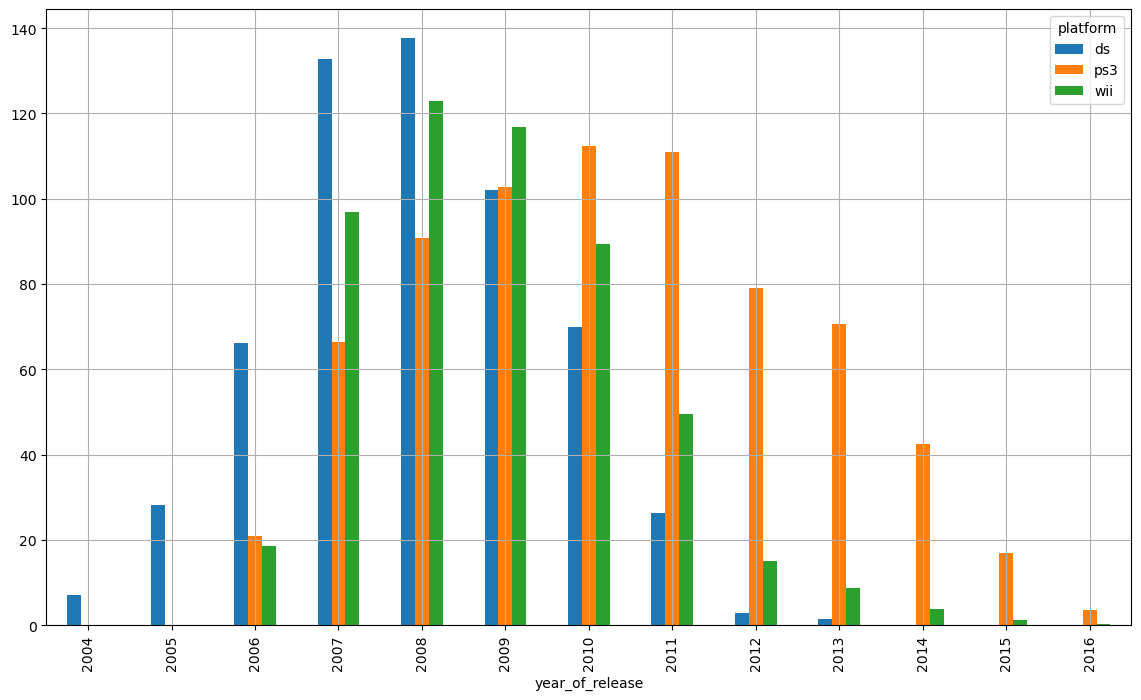

In [22]:
plataformas = df[ (( df['platform'] == 'wii')  |  (df['platform'] == 'ds') |  (df['platform'] == 'ps3')) & (df['year_of_release'] >= 2004)]
plataformas_data = plataformas.groupby(['year_of_release','platform'])['ventas_totales'].sum().reset_index(name='ventas_anual')

df_pivot = plataformas_data.pivot_table(index='year_of_release', columns='platform', values='ventas_anual')
df_pivot.plot(kind='bar', figsize=(14,8), grid=True) 

En la gráfica  anterior se aprecia la salida a la venda de los videojuegos de cada consola, el aumento de la venta de video juegos y la caida de venta de los mismo, dando una estimación de ganacias de 4 años para los la nintendo wii y nindtendo Ds y 5 años para la PS3 de sony.

Plataformas lideres en ventas, comprendido en el rango de años: 2008 - 2009, los cuales son los años con mayor numero en ventas de video juegos.

    1.-Nintendo Wii
    2.-Nintendo Ds
    3.-Sony PS3

Plataformas en crecimiento en ventas para el año 2017, segun el comportamientode la estadistica podrian clasificarse de la siguiente manera:



<Axes: xlabel='year_of_release'>

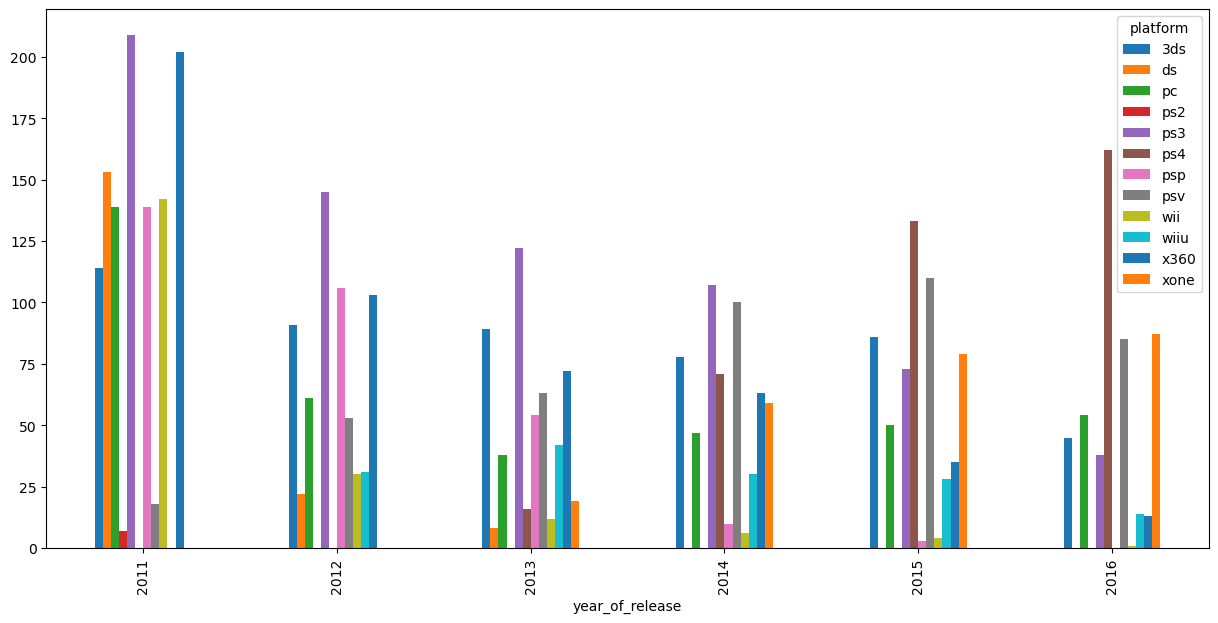

In [23]:

muestra = df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2017)]
muestra_group = muestra.groupby(['year_of_release','platform'])['platform'].count().reset_index(name='juegos_por_año')
df_pivot = muestra_group.pivot_table(index='year_of_release', columns='platform', values='juegos_por_año')
df_pivot.plot(kind='bar', figsize=(15,7)) 

En el gráfico  anterior se puede observar el ___crecimiento___ en ventas de la plataforma quedando de la siguinete manera:

    1.- Sony PS4
    2.- Microsoft Xbox One
    3.- PC

*aunque los juegos de PC no tiene el puesto #3 en ventas, si tiene el puesto # 3 en crecimineto de ventas por consola
*la consola PS4 y Xbox one, se encuentran en su 4to. año de lanzamiento, restan sole 2 años mas  en ventas, mismas que se veran en decaida en los proximos 2 años, a raíz de nuevas consolas por emerger.

De igual manera, en el mismo gráfico podemos apreciar las consolas que estan de decrecimiento, por que ya pasaron el climax o cresta de la curva de ventas utilies, quedando el listado de reducción de ventas de la siguiente manera:

    1.-Sony PS3
    2.-Microsoft Xbox 360
    3.-Nintendo wii u
    4.-Sony psp vita

PLataformas potencialemnete rentables:

    1.-Sony PS4
    2.-Microsoft Xbox one
    3.-Sony psp vita
    4.- PC


    *se incluye la Sony psps vita, a un que sea una consola que se encuetra en su etapa de salida, en 2016 tiene ventas muy aproximadas a la consola de Microsoft Xbox one que es la segundo lugar en ventas en 2016.

    *En 4to lugar tenemos a los videojuegos de PC, que aunque llevan estando casi en su totalidad a lo largo de la vida de los videojuegos, se mantiene constante en su ventas, existe un mercado de nicho para los videos juegos de PC.
    
    *Nota: si se desea tener un panorama en ventas para el 2017 y ya tenemos los valores de las ventas de 2016, para ese entonces ya se habia dado a concer la fecha de lanzamiento de la proxima consola de nintendo, la 'switch', que podria ser una consola que potencialmente podria acender y desplazar en ventas a una Sony psp vita.

### Ventas Globales

Text(0.5, 0, 'Plataformas')

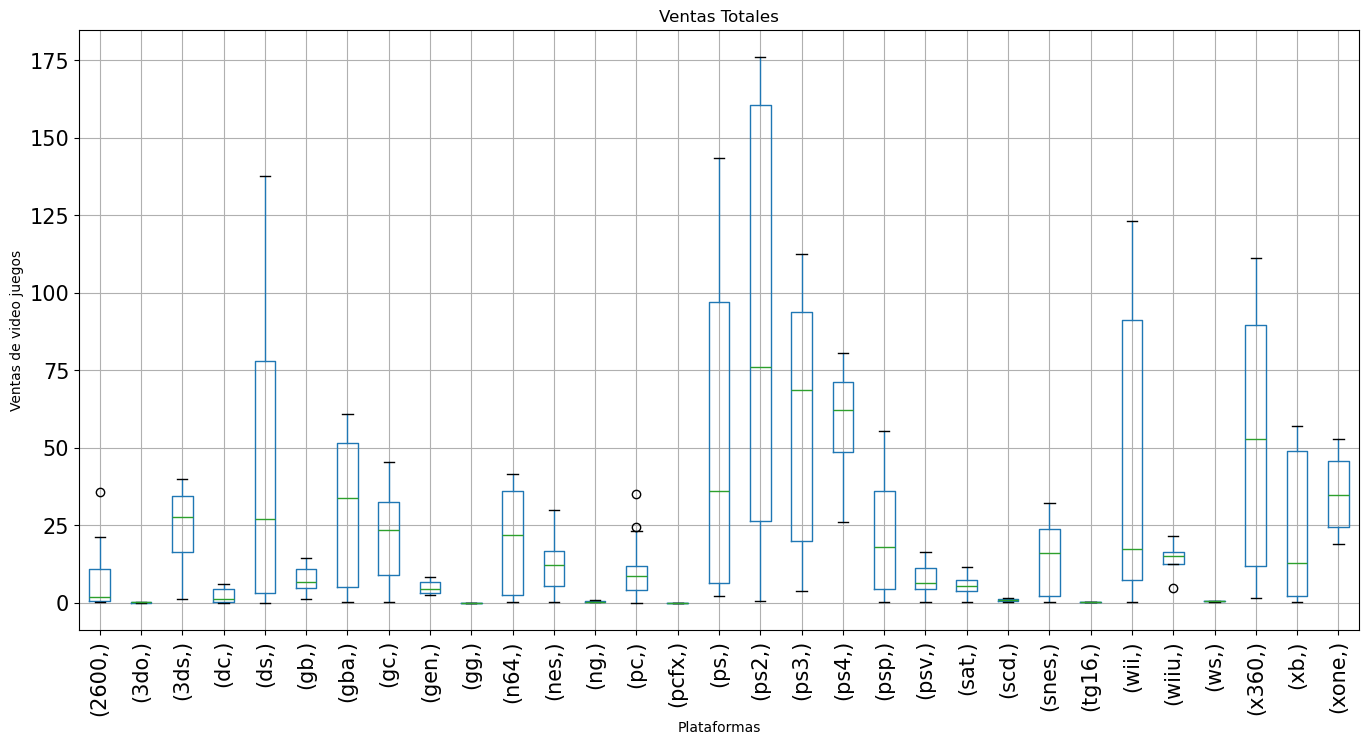

In [24]:

#agruar toda la informacion por plataforma y año de lanzamiento
grp = df.groupby(['platform','year_of_release'])

#agregamos funcion dpara sumar las ventas de cada plataforma
agg_dict = {'ventas_totales': 'sum'}
ventas_totales = grp.agg(agg_dict)

boxplot = ventas_totales.boxplot(
    column=['ventas_totales'],
    by=['platform'],
    rot=90,
    fontsize=15,
    figsize=(16,8),
    
    )

boxplot.get_figure().suptitle('')
boxplot.set_title('Ventas Totales')
boxplot.set_ylabel('Ventas de video juegos')
boxplot.set_xlabel('Plataformas')

Se puede apreciar las diferencias de las ventas totales por año entre las distintas plataformas, atravez de los años en que las plataformas han estado activas en ventas de video juegos.
y la suma de sus ventas de los disttos videos por año se hacen notar en la elongacion de cada una de las cajas. 

Text(0.5, 0, 'Plataformas')

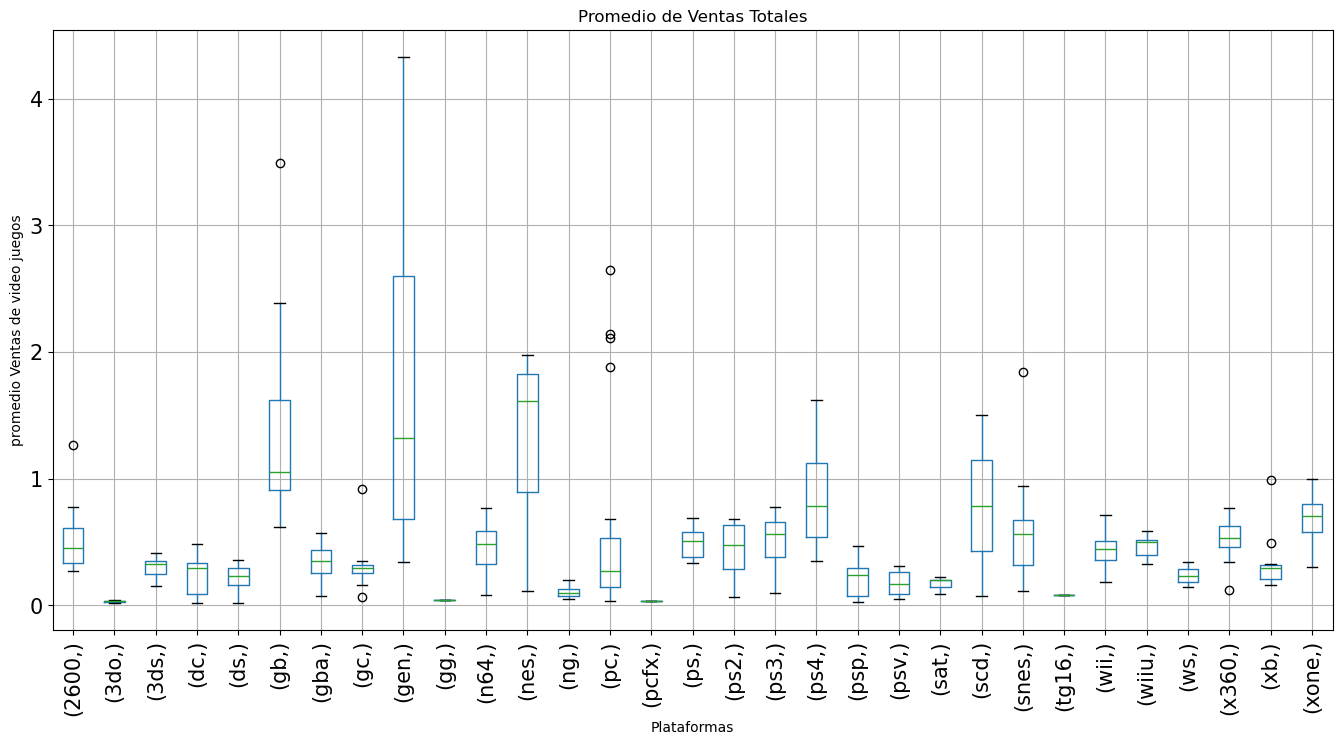

In [25]:

#agruar toda la informacion por plataforma y año de lanzamiento
grp = df.groupby(['platform','year_of_release'])

#agregamos funcion dpara sumar las ventas de cada plataforma
agg_dict = {'ventas_totales': 'mean'}
ventas_totales = grp.agg(agg_dict)

boxplot = ventas_totales.boxplot(
    column=['ventas_totales'],
    by=['platform'],
    rot=90,
    fontsize=15,
    figsize=(16,8),
    
    )

boxplot.get_figure().suptitle('')
boxplot.set_title('Promedio de Ventas Totales')
boxplot.set_ylabel('promedio Ventas de video juegos')
boxplot.set_xlabel('Plataformas')

In [26]:
#agruar toda la informacion por plataforma y año de lanzamiento
grp2 = df[df['platform'] == 'gb' ].groupby(['platform','year_of_release'])

#agregamos funcion dpara sumar las ventas de cada plataforma
agg_dict2 = {'ventas_totales': 'mean'}
ventas_totales_gb = grp2.agg(agg_dict2)
display(ventas_totales_gb)

ventas_totales
platform year_of_release                
gb       0                      1.030000
         1988                   1.430000
         1989                   1.604286
         1990                   1.630000
         1991                   0.618889
         1992                   2.385000
         1994                   3.495000
         1995                   0.900000
         1996                   0.930000
         1997                   0.796250
         1998                   1.751429
         1999                   1.066667
         2000                   0.835625
         2001                   0.924000

En la anterior grafica podemos observar el promedio de la distribucion de las ventas que tuvo cada plataforma en los años que estuvo disponible cada una. donde se puede apreciar la venta inminente de un video juego de la Nintedo Gb en el año de 1989, revasando los 6 puntos en ventas, para posteriomente le siguen, la 'ggen' y la 'n64'. las demas plataformas en los general

### El  efecto de las reseñas de usuarios y profesionales a las ventas de un plataforma

In [27]:
ventas_ps4 = df[df['platform'] == 'ps4' ]

display(ventas_ps4)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ventas_totales
225,The Last of Us,ps4,2014,action,1.88,2.00,0.07,0.77,Unknown,7.1,NaN,4.72
231,Uncharted: The Nathan Drake Collection,ps4,2015,action,2.07,1.71,0.08,0.76,86.0,8.1,T,4.62
245,Call of Duty: Infinite Warfare,ps4,2016,shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47
261,Minecraft,ps4,2014,misc,1.48,2.02,0.14,0.68,Unknown,7.1,NaN,4.32
289,Battlefield 1,ps4,2016,shooter,1.10,2.15,0.21,0.61,88.0,8.4,M,4.07
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,ps4,2016,adventure,0.00,0.00,0.01,0.00,69.0,7.5,NaN,0.01
16503,Shin Hayarigami 2,ps4,2016,adventure,0.00,0.00,0.01,0.00,Unknown,7.1,NaN,0.01
16526,Dungeons 2,ps4,2016,role-playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
16530,Carmageddon: Max Damage,ps4,2016,action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


#### Reseñas de los profesionales

correlacion = 0.4020802212343247 


[]

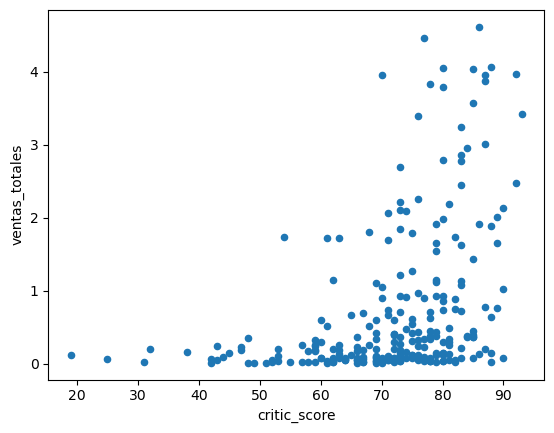

In [28]:

""" 
#old code
    correlacion = ventas_ps4['critic_score'].corr(ventas_ps4['ventas_totales'])
    print(f"correlacion = {correlacion} ")
    scatter_plot= ventas_ps4.plot.scatter(x='critic_score', y='ventas_totales')
    scatter_plot.plot()
"""
ventas_ps4_critic_score_wo_know_data = ventas_ps4[ ventas_ps4['critic_score'] !='Unknown' ]
correlacion = ventas_ps4_critic_score_wo_know_data['critic_score'].corr(ventas_ps4_critic_score_wo_know_data['ventas_totales'])
print(f"correlacion = {correlacion} ")
scatter_plot= ventas_ps4_critic_score_wo_know_data.plot.scatter(x='critic_score', y='ventas_totales')
scatter_plot.plot()

#### Reseñas de los Usuarios

correlacion = -0.013084620400498374


[]

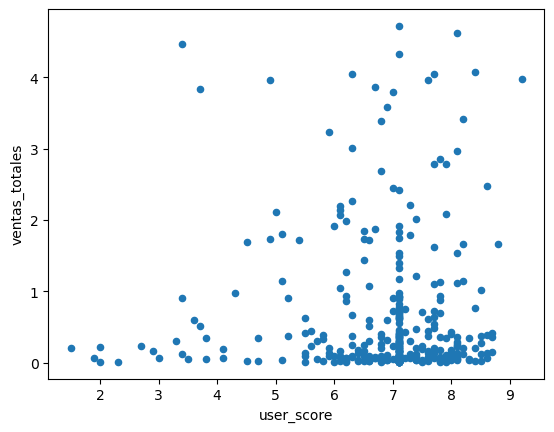

In [29]:
correlacion = ventas_ps4['user_score'].corr(ventas_ps4['ventas_totales'])
print(f"correlacion = {correlacion}")
scatter_plot= ventas_ps4.plot.scatter(x='user_score', y='ventas_totales')
scatter_plot.plot()

Se puede observar en las graficas anteriores que las ventas de videojuegos no esta ligada a las criticas de los usuarios y de los profesionales.

Vericar la relacion critica(usuario,profesional) con las ventas de un video juego en distintas 


para ello se tomara un videojuego que aparesca en distintas plataformas

In [30]:
data = df.groupby(['name'])['platform'].count().reset_index(name='cantidad')
data = data[ (data['cantidad'] > 2  )  ]
display(data.sort_values(by='cantidad', ascending=False).head(10))

,name,cantidad
6667,Need for Speed: Most Wanted,12
5107,LEGO Marvel Super Heroes,9
7714,Ratatouille,9
5434,Madden NFL 07,9
5104,LEGO Jurassic World,8
349,Angry Birds Star Wars,8
6027,Monopoly,8
9896,The LEGO Movie Videogame,8
1301,Cars,8
5116,LEGO Star Wars II: The Original Trilogy,8


correlacion = 0.27380802205649896


[]

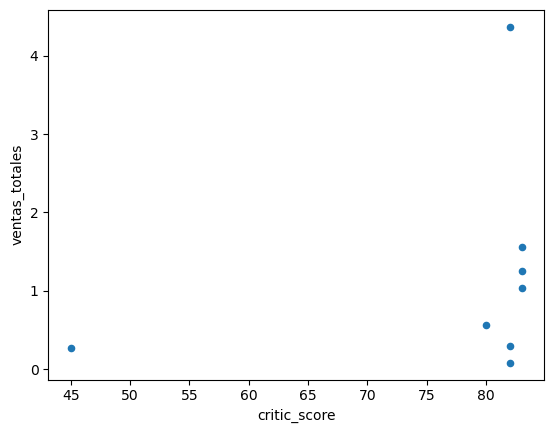

In [31]:

#seleccionar el video juego 'Need for Speed: Most Wanted'



juego_name = 'Need for Speed: Most Wanted'
data = df[(df['name'] == juego_name) & (df['critic_score'] != 'Unknown')]



correlacion = data['critic_score'].corr(data['ventas_totales'])
print(f"correlacion = {correlacion}")

scatter_plot= data.plot.scatter(x='critic_score', y='ventas_totales')
scatter_plot.plot()


correlacion = 0.39311668190042337


[]

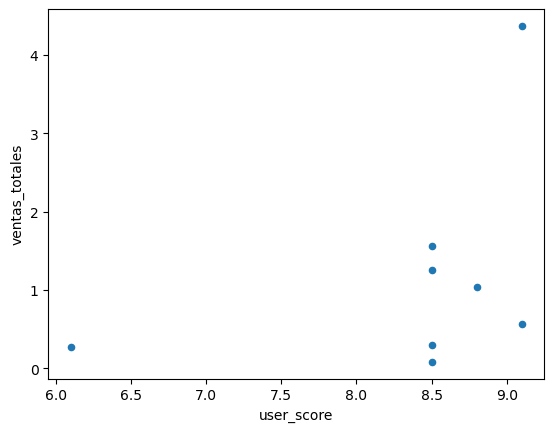

In [32]:

correlacion = data['user_score'].corr(data['ventas_totales'])
print(f"correlacion = {correlacion}")

scatter_plot= data.plot.scatter(x='user_score', y='ventas_totales')
scatter_plot.plot()

Las Correlaciones de ventas del mismo juego para diferentes plataformas en relación con una critica de una profesional o de un usuario no son lineales,

### Los géneros más rentables

In [33]:
#Seleccionamos los generos con mayores ventas
data_genero_ventas = df.groupby(['genre'])['ventas_totales'].sum().reset_index(name='total')
data_genero_ventas.sort_values(by='total', ascending=False, inplace=True)

data_genero_ventas.head(10)


,genre,total
0,action,1467.24
11,sports,1109.97
8,shooter,713.54
3,misc,646.18
7,role-playing,644.71
6,racing,541.78
4,platform,500.89
2,fighting,395.31
9,simulation,325.14
1,adventure,220.86


Se puede concluir simple vista que los generos a los largo del tiempo han jugado un roll importante, situandose a la cabeza el genero de acción, en un segundo lugar los juegos de deportes y en un tercer lugar los de shooter.

Se procedera a realizar un analisis de los mismos datos, para agrupado por la plataforma

In [34]:
data_genero_ventas = df.groupby(['genre','platform'])['ventas_totales'].sum().reset_index(name='total')
data_genero_ventas.sort_values(by='total', ascending=False, inplace=True)

data_genero_ventas.head(20)

,genre,platform,total
259,sports,ps2,268.24
12,action,ps2,216.60
13,action,ps3,212.68
21,action,x360,195.52
93,misc,wii,137.14
268,sports,x360,132.15
219,shooter,x360,129.07
258,sports,ps,120.95
260,sports,ps3,120.68
158,racing,ps2,115.67


Se puede observar, a diferencia de los datos obtenenidos en un inicio, las ventas de videosjuegos de algun genero han variado por el tipo de plataforma, es necesario realizar un analisis a detalle sobre los videosjuegos, si estos son exlusivos de alguna plataforma o no. asi como si son exclusivos de una generación de plataformas.

# Paso 4. Perfil de usuario <a id='perfil'></a>

### Las cinco plataformas principales

In [35]:
grp = df.groupby(['platform'])
agg_dict= {'na_sales': 'sum','eu_sales': 'sum','jp_sales': 'sum','ventas_totales': 'sum'}
			

top_5_plataformas = grp.agg(agg_dict)
top_5_plataformas.sort_values(by='ventas_totales', ascending=False, inplace=True)
top_5_plataformas = top_5_plataformas.head(5)
display(top_5_plataformas)


,na_sales,eu_sales,jp_sales,ventas_totales
platform,,,,
ps2,520.46,305.53,121.33,1110.56
ps3,310.89,243.23,70.19,725.16
x360,444.99,203.35,10.34,722.42
ps,295.02,182.42,116.45,629.74
ds,303.93,116.87,116.44,577.52


Se puede apreciar el top 5 en ventas de la tabla anterior que, el número mayor de ventas por región en todas las plataformas es norte america, le sigue la unión europea y al final japon.

### Los cinco géneros principales

In [36]:
grp = df.groupby(['genre'])
agg_dict= {'na_sales': 'sum','eu_sales': 'sum','jp_sales': 'sum','ventas_totales': 'sum'}
			

top_5_genero = grp.agg(agg_dict)
top_5_genero.sort_values(by='ventas_totales', ascending=False, inplace=True)
top_5_genero = top_5_genero.head(5)
display(top_5_genero)

,na_sales,eu_sales,jp_sales,ventas_totales
genre,,,,
action,751.14,428.77,143.93,1467.24
sports,591.13,287.20,121.29,1109.97
shooter,391.32,219.57,32.82,713.54
misc,331.99,161.91,92.09,646.18
role-playing,228.12,111.35,262.86,644.71


Sin duda alguna el genero de acción es quien se lleva por mucho a los demas generos, donde se puede decir que los generos de acción son videojuegos que se basan en luchar y pelear para lograr un objetivo, seguido de la tematica de deportes, en la tercera posición se encuetran los juegos de disparar al opónente o a un objetivo, seguidos por los RPG y los de plataforma,
se aprecia la gran influencia que tiene los video jueos de violencia en las regiones de se comercializan.


### Clasificaciones de ESRB

Existen 6766 de valores nulos en la columna 'rating' dando un 40.47% sobre la cantidad total de registros faltantes.

In [37]:
#seleccionar el video juego 'Need for Speed: Most Wanted'

#data = df[ df['name'] == 'Need for Speed: Most Wanted']

#correlacion = data['rating'].corr(data['ventas_totales'])
#print(f"correlacion = {correlacion}")

#scatter_plot= data.plot.scatter(x='rating', y='ventas_totales')
#scatter_plot.plot()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16525 entries, 190 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16523 non-null  object 
 1   platform         16525 non-null  object 
 2   year_of_release  16525 non-null  int32  
 3   genre            16525 non-null  object 
 4   na_sales         16525 non-null  float64
 5   eu_sales         16525 non-null  float64
 6   jp_sales         16525 non-null  float64
 7   other_sales      16525 non-null  float64
 8   critic_score     16525 non-null  object 
 9   user_score       16525 non-null  float64
 10  rating           9814 non-null   object 
 11  ventas_totales   16525 non-null  float64
dtypes: float64(6), int32(1), object(5)
memory usage: 1.6+ MB


# Paso 5. Hipótesis <a id='hypothesis'></a>

### Calificaciones promedio para las paltaformas Xbox one y PC

In [38]:
# Prueba las hipótesis

#hipotesis nula
H0 = 'Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.'

#hipotesis alternativa
H1 = 'Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.'


#conjunto de valores de la plataforma X box one
Xbox_one = df[df['platform'] == 'xone']['user_score']

#conjunto de valores de la plataforma PC
Pc = df[df['platform'] == 'pc']['user_score']

#Eliminamos vales ausentes en ambos conjuntos de datos
Xbox_one =  Xbox_one.dropna()
Pc =  Pc.dropna()

#Determinar el valor de alpha
alpha = 0.05

In [39]:
results = st.ttest_ind(Xbox_one,Pc,equal_var=False)

print('valor p:',results.pvalue)

#verificamos con la condicion el valor de p contra el valor de alpha 
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
    print(H0)
else:
    print("No podemos rechazar la hipótesis nula")
    print(H1)

valor p: 1.0636087270098911e-05
Rechazamos la hipótesis nula
Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.


### Calificaciones promedio para los generos Acción y Deportes


In [40]:
# Prueba las hipótesis

#hipotesis nula
H0 = 'Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.'

#hipotesis alternativa
H1 = 'Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes NO son diferentes.'


#conjunto de valores de la plataforma X box one

accion = df[df['genre'] == 'action']['user_score']

#conjunto de valores de la plataforma PC
depores = df[df['genre'] == 'sports']['user_score']

#Eliminamos vales ausentes en ambos conjuntos de datos
accion =  accion.dropna()
depores =  depores.dropna()

#Determinar el valor de alpha
alpha = 0.05

In [41]:

#codigo anterior, antes de la primera revision
#results = st.ttest_ind(accion,depores,equal_var=False)


varianza_accion = accion.var()
varianza_depores = depores.var()


#codigo nuevo, depues de la primera revision
try:
    # Intenta realizar la prueba de Levene con equal_var

    #results = levene(accion, depores, equal_var=False)
    #results = levene(accion, depores, center='median' )
    results = levene(varianza_accion, varianza_depores, center='median' )

except TypeError:
    # Si equal_var no es admitido, realiza la prueba sin especificarlo
    results = levene(accion, depores)

    """
    me arroja el siguiente error
    'TypeError: levene() got an unexpected keyword argument 'equal_var' '
    
    lei que no admite el argumento 'equal_var' y que se debe de calcular con la opción center='median'
    """

In [42]:
# de la prueba levene
print('valor p:',results.pvalue)

#verificamos con la condicion el valor de p contra el valor de alpha 
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
    print(H0)
else:
    print("No podemos rechazar la hipótesis nula")
    print(H1)

valor p: 0.789020218009921
No podemos rechazar la hipótesis nula
Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes NO son diferentes.


In [43]:


#se rechaza la hipótesis de varianzas iguales, colocamos 'equal_var=False', como parametro en la funcion st.ttest_ind
results = st.ttest_ind(accion,depores,equal_var=False)

print('valor p:',results.pvalue)

#verificamos con la condicion el valor de p contra el valor de alpha 
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
    print(H0)
else:
    print("No podemos rechazar la hipótesis nula")
    print(H1)

valor p: 0.34003247984949225
No podemos rechazar la hipótesis nula
Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes NO son diferentes.


# Paso 6. Conclusión <a id='conclusion_general'></a>

Después de realizar el análisis y la observación de los datos, se puede concluir la tendencia del tiempo estimado de vida de una consola, lo cual nos permitirá determinar qué tan conveniente sería lanzar un videojuego para dicha consola, según su tiempo de vida. Además, se puede proporcionar información sobre la disponibilidad de stock en tiendas en relación con la demanda prevista de algún título de videojuego. Asimismo, se observa la venta de videojuegos con respecto al género.